In [74]:
import pyodbc
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from matplotlib import style
style.use('fivethirtyeight')

In [75]:
# Connect to the Database
cnxn = pyodbc.connect("Driver={SQL Server Native Client 11.0};"
                        "Server=wd02;"
                        "Database=FootPrint;"
                        "Trusted_Connection=yes;")

# QUERY 01: Operations

In [76]:
df = pd.read_sql_query("DECLARE @from date, @to date;\
    SELECT\
        @from = getdate()\
        ,@to = dateadd(day, 1, getdate());\
\
SELECT CONVERT(varchar,t.completedDateTime,100) Date, w.name warehouse, p.name project, oc.name operationCode, t.employee\
    FROM datex_footprint.Tasks t\
    JOIN datex_footprint.OperationCodes oc\
        ON oc.id = t.operationCodeId\
    JOIN datex_footprint.Warehouses w\
        ON w.id = t.warehouseId\
    JOIN datex_footprint.Projects p\
        ON p.id = t.projectId\
    WHERE t.completedDateTime >= @from AND t.completedDateTime < @to AND (t.employee != 'FootPrintService') AND (t.employee != 'Foot Print Service') and t.statusId = 2", cnxn)

In [77]:
# Adding Hours
df['Hour'] = pd.to_datetime(df['Date']).dt.hour
df.head()

,Date,warehouse,project,operationCode,employee,Hour
0,Apr 6 2022 9:54AM,10,"ACI Healthcare USA, Inc.",Receiving,Hernando Sanchez,9
1,Apr 6 2022 9:55AM,10,"ACI Healthcare USA, Inc.",Receiving,Hernando Sanchez,9
2,Apr 6 2022 9:56AM,10,"ACI Healthcare USA, Inc.",Receiving,Hernando Sanchez,9
3,Apr 6 2022 9:56AM,10,"ACI Healthcare USA, Inc.",Receiving,Hernando Sanchez,9
4,Apr 6 2022 11:38AM,20,"ACI Healthcare USA, Inc.",Receiving,Marzetta Bracken,11


# WAREHOUSE

In [78]:
# Group By Warehouse
df_warehouse = df.groupby(['warehouse']).count()[['operationCode']]
df_warehouse.reset_index(inplace=True)
df_warehouse.head()

,warehouse,operationCode
0,10,1286
1,102,30
2,12,41
3,15,527
4,16,63


In [79]:
# Pie Chart
warehouse = df_warehouse['warehouse']
activity = df_warehouse['operationCode']

#plt.subplots(figsize=(8,8))
#plt.pie(activity, labels=warehouse)
#plt.show()

In [80]:
# Bar Chart
warehouse = df_warehouse['warehouse']
activity = df_warehouse['operationCode']

#plt.subplots(figsize=(8,8))
#plt.bar(warehouse, activity)
#plt.show()

In [81]:
# Save Data in JSON format
df_warehouse_index = df_warehouse.set_index(['warehouse'])
df_warehouse_index.to_json('data/warehouse.json')
df_warehouse_index.head()

,operationCode
warehouse,
10,1286
102,30
12,41
15,527
16,63


### All Operations type

In [82]:
df_operation = df.groupby(['operationCode']).count()[['project']]
df_operation.reset_index(inplace=True)
df_operation.head()

,operationCode,project
0,Batch Move,76
1,Count,65
2,Create Inventory,1
3,DONE RECEIVING,10
4,DRIVER CHECK IN,19


In [83]:
# Horizontal Bar Chart
values = df_operation['project']
operation = df_operation['operationCode']

#plt.subplots(figsize=(8,8))
#plt.barh(operation, values)
#plt.gca().invert_yaxis()
#plt.show()

In [84]:
df_operation.rename(columns={"project": "Tasks"})
df_operation.head()

,operationCode,project
0,Batch Move,76
1,Count,65
2,Create Inventory,1
3,DONE RECEIVING,10
4,DRIVER CHECK IN,19


In [85]:
# Save Data in JSON format
df_operation = df_operation.rename(columns={"project": "Tasks"})
df_operation_index = df_operation.set_index(['operationCode'])
df_operation_index.to_json('data/operations_type.json')
df_operation_index.head()

,Tasks
operationCode,
Batch Move,76
Count,65
Create Inventory,1
DONE RECEIVING,10
DRIVER CHECK IN,19


### Excluding Operations PICKING and RECEIVING

In [86]:
df_operation_excluded = df_operation.loc[(df_operation["operationCode"] != 'Picking') &
                                         (df_operation["operationCode"] != 'Receiving')]

In [87]:
# Save Data in JSON format
df_operation_excluded = df_operation_excluded.rename(columns={"project": "Tasks"})
df_operation_excluded_index = df_operation_excluded.set_index(['operationCode'])
df_operation_excluded_index.to_json('data/operations_type_excluded.json')
df_operation_excluded_index.head()

,Tasks
operationCode,
Batch Move,76
Count,65
Create Inventory,1
DONE RECEIVING,10
DRIVER CHECK IN,19


### Operations per Hour

In [88]:
df_hours = df.groupby(['Hour']).count()[['operationCode']]
df_hours.reset_index(inplace=True)
df_hours.head()

,Hour,operationCode
0,7,87
1,8,322
2,9,341
3,10,690
4,11,499


In [89]:
# Bar Chart
hour = df_hours['Hour']
activity = df_hours['operationCode']

#plt.subplots(figsize=(8,8))
#plt.bar(hour, activity)
#plt.xticks(hour)
#plt.show()

In [90]:
df_hours = df_hours.rename(columns={'operationCode': 'Operations'})
df_hours_index = df_hours.set_index(['Hour'])
df_hours_index.to_json('data/hours.json')
df_hours_index.head()

,Operations
Hour,
7,87
8,322
9,341
10,690
11,499


# PICKING

In [91]:
# Filtered by Picking
df_picking = df[df['operationCode'] == 'Picking']

In [92]:
# Grouped by Employee and Hour
df_picking_grouped = df_picking.groupby(['employee', 'Hour']).count()[['operationCode']]
df_picking_grouped.reset_index(inplace=True)
df_picking_grouped.head()

,employee,Hour,operationCode
0,Aisha Cooper,8,9
1,Aisha Cooper,9,3
2,Aisha Cooper,10,11
3,Aisha Cooper,11,1
4,Aisha Cooper,12,5


In [93]:
# Pivot
df_picking_pivoted = df_picking_grouped.pivot(index='employee', columns='Hour', values='operationCode')
df_picking_pivoted = df_picking_pivoted.fillna(0)
df_picking_pivoted = df_picking_pivoted.rename_axis(None, axis=1)
#df_picking_pivoted.reset_index(inplace=True)

df_picking_pivoted.head()

,7,8,9,10,11,12,13,14,15
employee,,,,,,,,,
Aisha Cooper,0.0,9.0,3.0,11.0,1.0,5.0,0.0,0.0,0.0
Alejandro Aguirre,0.0,12.0,7.0,0.0,0.0,0.0,0.0,4.0,7.0
Angel Luna,0.0,8.0,7.0,0.0,0.0,0.0,0.0,0.0,0.0
Angela Pena,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,25.0
Brad Bacchetti,0.0,0.0,1.0,0.0,5.0,35.0,0.0,0.0,0.0


### Save in JSON File

In [94]:
# Save into JSON
pickers = df_picking_pivoted.T
pickers.to_json('data/pickers.json')
pickers.head()

employee,Aisha Cooper,Alejandro Aguirre,Angel Luna,Angela Pena,Brad Bacchetti,Carlos Gomez,Dan Parisi,Danielle Lucas,Edilberto Souza,Ernest Ferguson,...,Raul Bejarano,Reggie Bracken,Ronald Celis,Shawn Saunders,Sujelin Soto-Orta,Wayne Gray,Wendy Medrano,William Trevino Trevino,Yaima Castillo,yudisel tubella
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,23.0,0.0,0.0,0.0
8,9.0,12.0,8.0,0.0,0.0,0.0,0.0,7.0,10.0,6.0,...,6.0,0.0,34.0,5.0,0.0,0.0,41.0,0.0,0.0,0.0
9,3.0,7.0,7.0,0.0,1.0,13.0,0.0,0.0,12.0,4.0,...,4.0,0.0,29.0,13.0,0.0,0.0,29.0,0.0,0.0,0.0
10,11.0,0.0,0.0,0.0,0.0,7.0,0.0,0.0,3.0,0.0,...,0.0,0.0,0.0,8.0,0.0,0.0,43.0,0.0,25.0,15.0
11,1.0,0.0,0.0,0.0,5.0,5.0,0.0,0.0,7.0,3.0,...,0.0,0.0,0.0,1.0,0.0,0.0,54.0,2.0,1.0,3.0


### Picking By Warehouse Function

In [95]:
# Picking Function
def picking_by_warehouse (warehouse):
    # Filter by warehouse
    df_w = df_picking[df_picking['warehouse'] == warehouse]
    
    # Grouped by Employee and Hour
    df_w_group = df_w.groupby(['employee', 'Hour']).count()[['operationCode']]
    df_w_group.reset_index(inplace=True)
    
    # Pivot
    df_w_pivot = df_w_group.pivot(index='employee', columns='Hour', values='operationCode')
    df_w_pivot = df_w_pivot.fillna(0)
    df_w_pivot = df_w_pivot.rename_axis(None, axis=1)
    
    # Save into JSON
    pickers_df = df_w_pivot.T
    file_name = f'data/pickers_w{warehouse}.json'
    pickers_df.to_json(file_name)

In [96]:
# Save warehouse data into JSON files
picking_by_warehouse('10')
picking_by_warehouse('12')
picking_by_warehouse('15')
picking_by_warehouse('16')
picking_by_warehouse('18')
picking_by_warehouse('19')
picking_by_warehouse('20')
picking_by_warehouse('21')
picking_by_warehouse('22')

# RECEIVING

In [97]:
# Filtered by Picking
receiving_df = df[df['operationCode'] == 'Receiving']
receiving_df.head()

,Date,warehouse,project,operationCode,employee,Hour
0,Apr 6 2022 9:54AM,10,"ACI Healthcare USA, Inc.",Receiving,Hernando Sanchez,9
1,Apr 6 2022 9:55AM,10,"ACI Healthcare USA, Inc.",Receiving,Hernando Sanchez,9
2,Apr 6 2022 9:56AM,10,"ACI Healthcare USA, Inc.",Receiving,Hernando Sanchez,9
3,Apr 6 2022 9:56AM,10,"ACI Healthcare USA, Inc.",Receiving,Hernando Sanchez,9
4,Apr 6 2022 11:38AM,20,"ACI Healthcare USA, Inc.",Receiving,Marzetta Bracken,11


In [98]:
# Grouped by Employee and Hour
receiving_group_df = receiving_df.groupby(['employee', 'Hour']).count()[['operationCode']]
receiving_group_df.reset_index(inplace=True)
receiving_group_df.head()

,employee,Hour,operationCode
0,Angela Briceno,10,2
1,Brad Bacchetti,11,41
2,Brad Bacchetti,14,1
3,Carlos Chavez,10,24
4,Casey Brown,12,24


In [99]:
# Pivot
receiving_pivot_df = receiving_group_df.pivot(index='employee', columns='Hour', values='operationCode')
receiving_pivot_df = receiving_pivot_df.fillna(0)
receiving_pivot_df = receiving_pivot_df.rename_axis(None, axis=1)
#df_picking_pivoted.reset_index(inplace=True)

receiving_pivot_df.head()

,7,8,9,10,11,12,13,14,15
employee,,,,,,,,,
Angela Briceno,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0
Brad Bacchetti,0.0,0.0,0.0,0.0,41.0,0.0,0.0,1.0,0.0
Carlos Chavez,0.0,0.0,0.0,24.0,0.0,0.0,0.0,0.0,0.0
Casey Brown,0.0,0.0,0.0,0.0,0.0,24.0,0.0,0.0,0.0
Chris Martin,20.0,0.0,0.0,7.0,0.0,0.0,0.0,0.0,0.0


In [100]:
# Save into JSON
receivers = receiving_pivot_df.T
receivers.to_json('data/receivers.json')
receivers.head()

employee,Angela Briceno,Brad Bacchetti,Carlos Chavez,Casey Brown,Chris Martin,Dan Parisi,Danielle Lucas,Djenyson Sanon,Hector Gonzalez,Hernando Sanchez,Jamarcus Cook,Justin Runsdorf,Luci Nicley,Marzetta Bracken,Omar Robles,Sandra Vega,Tyler Gonzales,Yulieth Aguirre
7,0.0,0.0,0.0,0.0,20.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,0.0,0.0,0.0,0.0,0.0,0.0,7.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,38.0,0.0,0.0
9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,26.0,0.0,15.0,0.0,0.0,0.0,0.0,1.0,4.0,0.0,0.0
10,2.0,0.0,24.0,0.0,7.0,0.0,0.0,3.0,0.0,1.0,8.0,0.0,10.0,0.0,0.0,0.0,0.0,0.0
11,0.0,41.0,0.0,0.0,0.0,0.0,0.0,0.0,14.0,1.0,4.0,0.0,0.0,14.0,2.0,0.0,11.0,0.0


# INVENTORY

In [101]:
# Group By Operation Code and Warehouse
cycle_count_df = df.groupby(['operationCode', 'warehouse']).count()[['employee']]
cycle_count_df.reset_index(inplace=True)

In [102]:
# Filtering by Count, Recount and Inventory Adjustment
cc_df = cycle_count_df.loc[(cycle_count_df["operationCode"] == 'Count') |
                           (cycle_count_df["operationCode"] == 'Recount') |
                           (cycle_count_df["operationCode"] == 'Inventory Adjustment')]

cc_df = cc_df.rename(columns={'employee': 'count'})

In [103]:
cc_df_pivot = cc_df.pivot(index='operationCode', columns='warehouse', values='count')

In [104]:
try:
    cc_df_pivot.rename({'Count': 'Inventory Counts'}, axis='index', inplace=True)
except:
    print('Operation COUNT does not exist yet')
    
try:
    cc_df_pivot.rename({'Recount': 'Discrepancies'}, axis='index', inplace=True)
except:
    print('Operation DISCREPANCIES does not exist yet')
    
try:
    cc_df_pivot.rename({'Inventory Adjustment': 'Inventory Adjustments'}, axis='index', inplace=True)
except:
    print('Operation INVENTORY ADJUSTMENT does not exist yet')

In [105]:
cc_df_pivot = cc_df_pivot.fillna(0)
cc_df_pivot.to_json('data/cycle_count.json')
cc_df_pivot.head()

warehouse,10,12,15,18,20
operationCode,,,,,
Inventory Counts,14.0,0.0,40.0,0.0,11.0
Inventory Adjustments,64.0,1.0,2.0,1.0,4.0


# QUERY 02: Open Outbounds

In [106]:
df_02 = pd.read_sql_query("SELECT DISTINCT w.name warehouse, p.name project, s.lookupCode shipment_number, s.createdSysDateTime\
    FROM datex_footprint.shipments s\
    LEFT JOIN datex_footprint.ShipmentOrderLookup sol\
        on sol.shipmentId = s.id\
    LEFT JOIN datex_footprint.orders o\
        on o.id = sol.orderId\
    LEFT JOIN datex_footprint.Projects p\
        on p.id = o.projectId\
    LEFT JOIN datex_footprint.warehouses w\
        on w.id = isnull(s.actualWarehouseId, s.expectedWarehouseId)\
    WHERE s.statusId in (1, 2, 4) and s.typeId = 2\
    ORDER BY createdSysDateTime", cnxn)

In [107]:
df_02.head()

,warehouse,project,shipment_number,createdSysDateTime
0,17,"TherapeuticsMD, Inc.",489832,2017-07-26 09:09:09.197
1,19,"Novadoz Pharmaceuticals, LLC",1901075,2019-09-30 10:50:10.143
2,10,"Chadwick Pharmaceuticals, Inc.",2167054,2019-11-14 16:36:44.793
3,10,Eywa Pharma Inc.,2475492,2020-01-22 13:20:13.063
4,10,Eywa Pharma Inc.,2475493,2020-01-22 13:20:13.447


In [108]:
df_02['age_order'] = pd.Timestamp.now() - df_02['createdSysDateTime']
df_02.head()

,warehouse,project,shipment_number,createdSysDateTime,age_order
0,17,"TherapeuticsMD, Inc.",489832,2017-07-26 09:09:09.197,1715 days 06:19:11.280197
1,19,"Novadoz Pharmaceuticals, LLC",1901075,2019-09-30 10:50:10.143,919 days 04:38:10.334197
2,10,"Chadwick Pharmaceuticals, Inc.",2167054,2019-11-14 16:36:44.793,873 days 22:51:35.684197
3,10,Eywa Pharma Inc.,2475492,2020-01-22 13:20:13.063,805 days 02:08:07.414197
4,10,Eywa Pharma Inc.,2475493,2020-01-22 13:20:13.447,805 days 02:08:07.030197


In [109]:
df_02['age_order_days'] = df_02['age_order'].dt.components['days']
df_02['age_order_hours'] = df_02['age_order'].dt.components['hours']
df_02.head()

,warehouse,project,shipment_number,createdSysDateTime,age_order,age_order_days,age_order_hours
0,17,"TherapeuticsMD, Inc.",489832,2017-07-26 09:09:09.197,1715 days 06:19:11.280197,1715,6
1,19,"Novadoz Pharmaceuticals, LLC",1901075,2019-09-30 10:50:10.143,919 days 04:38:10.334197,919,4
2,10,"Chadwick Pharmaceuticals, Inc.",2167054,2019-11-14 16:36:44.793,873 days 22:51:35.684197,873,22
3,10,Eywa Pharma Inc.,2475492,2020-01-22 13:20:13.063,805 days 02:08:07.414197,805,2
4,10,Eywa Pharma Inc.,2475493,2020-01-22 13:20:13.447,805 days 02:08:07.030197,805,2


In [110]:
bins =[-1,1,2,3,7,30,60, 90,365, 730,10000]
bin_names = ['24 Hours', '48 Hours', '72 Hours', '1 Week', '1 Month', '2 Months', '3 Months', '1 Year', '2 Years', 'More than 2 years']

df_02['age_group'] = pd.cut(df_02['age_order_days'], bins, labels=bin_names)

In [111]:
df_02_grouped = df_02.groupby(['age_group'])[['project']].count()

In [112]:
df_02_grouped = df_02_grouped.rename(columns={'project': 'orders'})

In [113]:
df_02_grouped

,orders
age_group,
24 Hours,862
48 Hours,259
72 Hours,7
1 Week,436
1 Month,1050
2 Months,642
3 Months,623
1 Year,2261
2 Years,1051


### Save in JSON File

In [114]:
open_outbounds = df_02_grouped
open_outbounds.to_json('data/open_outbounds.json')
open_outbounds

,orders
age_group,
24 Hours,862
48 Hours,259
72 Hours,7
1 Week,436
1 Month,1050
2 Months,642
3 Months,623
1 Year,2261
2 Years,1051


<AxesSubplot:ylabel='age_group'>

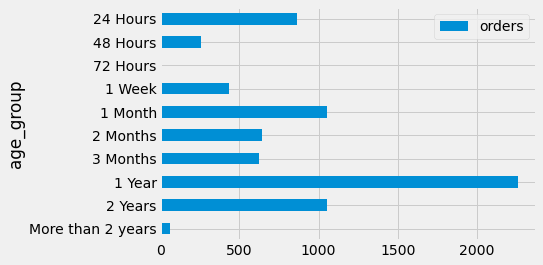

In [115]:
df_02_grouped = df_02_grouped.iloc[::-1]
df_02_grouped.plot.barh()

# QUERY 3: Picking Performance (Orders and Waves)

In [116]:
df03 = pd.read_sql_query("DECLARE @from date, @to date;\
                          SELECT @from = getdate(), @to = dateadd(day, 1, getdate());\
    SELECT t.completedDateTime Date, oc.name Operation, w.name Warehouse,\
           p.name Project, m.lookupCode Material, employee Employee, s.lookupCode Shipment, isnull(s.waveId, ps.waveId) Wave,\
           ordersPerWave.shipmentsCount, lc.name Location\
    FROM datex_footprint.Tasks t\
        join datex_footprint.OperationCodes oc\
            on oc.id = t.operationCodeId\
        left join datex_footprint.Warehouses w\
            on w.id = t.warehouseId\
        left join datex_footprint.Projects p\
            on p.id = t.projectId\
        left join datex_footprint.Materials m\
            on m.id = t.materialId\
        left join datex_footprint.Shipments s\
            on s.id = t.shipmentId\
        left join datex_footprint.PickSlips ps\
            on ps.id = t.pickSlipId\
        left join datex_footprint.LocationContainers lc\
            on lc.id = t.actualSourceLocationId\
        outer apply (\
            select\
                count(distinct tt.shipmentId) shipmentsCount\
                from datex_footprint.waves ww\
                    inner join datex_footprint.PickSlips ppss\
                    inner join datex_footprint.tasks tt\
                        on tt.operationCodeId = 8 and tt.pickSlipId = ppss.id\
                        on ppss.waveId = ww.id\
                where ww.id = isnull(s.waveId, ps.waveId)) ordersPerWave\
    where t.completedDateTime >= @from and t.completedDateTime < @to and t.statusId = 2\
    and t.operationCodeId in (8, 39, 2064, 2065, 2066) and t.employee != 'Foot Print Service'\
    order by s.lookupCode, t.completedDateTime", cnxn)

In [117]:
df03.tail(3)

,Date,Operation,Warehouse,Project,Material,Employee,Shipment,Wave,shipmentsCount,Location
2626,2022-04-06 09:06:41.087,Scanned Shipment,19,"GCH Granules USA, Inc.",None,Brad Bacchetti,TR-WN-04062022-B,233254.0,1,None
2627,2022-04-06 09:07:38.107,Picking,19,"GCH Granules USA, Inc.",700000000834,Brad Bacchetti,TR-WN-04062022-B,233254.0,1,40-08-01-A
2628,2022-04-06 09:08:02.933,Picking Completed,19,"GCH Granules USA, Inc.",None,Brad Bacchetti,TR-WN-04062022-B,233254.0,1,None


In [118]:
# Order Columns
df03 = df03[['Warehouse', 'Project', 'Wave', 'Shipment', 'Date', 'Operation', 'Employee',
             'Location', 'shipmentsCount', 'Material']]

### Filter by Shipments

In [119]:
# Filter by Orders only
df03_orders = df03.loc[(df03['Operation']=='Picking') |
                       (df03['Operation']=='Scanned Shipment') |
                       (df03['Operation']=='Picking Completed')]

df03_orders = df03_orders[['Warehouse', 'Project', 'Shipment', 'Date', 'Operation', 'Employee', 'Location']]

df03_orders.head()

,Warehouse,Project,Shipment,Date,Operation,Employee,Location
105,10,ISDIN Corporation,0085579073,2022-04-06 12:26:04.870,Scanned Shipment,Hugo Gonzales,None
106,10,ISDIN Corporation,0085579073,2022-04-06 12:26:54.907,Picking,Hugo Gonzales,33-01-01-B
107,10,ISDIN Corporation,0085579073,2022-04-06 12:27:02.123,Picking Completed,Hugo Gonzales,None
108,10,ISDIN Corporation,0085579073,2022-04-06 12:27:52.470,Picking,Hugo Gonzales,33-01-02-B
109,10,ISDIN Corporation,0085579073,2022-04-06 12:29:16.627,Picking,Hugo Gonzales,33-01-02-B


In [120]:
# Create a new column with the time difference between rows
df03_orders['PickingTime'] = df03_orders['Date'].diff()
df03_orders.head()

,Warehouse,Project,Shipment,Date,Operation,Employee,Location,PickingTime
105,10,ISDIN Corporation,0085579073,2022-04-06 12:26:04.870,Scanned Shipment,Hugo Gonzales,None,NaT
106,10,ISDIN Corporation,0085579073,2022-04-06 12:26:54.907,Picking,Hugo Gonzales,33-01-01-B,0 days 00:00:50.037000
107,10,ISDIN Corporation,0085579073,2022-04-06 12:27:02.123,Picking Completed,Hugo Gonzales,None,0 days 00:00:07.216000
108,10,ISDIN Corporation,0085579073,2022-04-06 12:27:52.470,Picking,Hugo Gonzales,33-01-02-B,0 days 00:00:50.347000
109,10,ISDIN Corporation,0085579073,2022-04-06 12:29:16.627,Picking,Hugo Gonzales,33-01-02-B,0 days 00:01:24.157000


In [121]:
# Add Hour, Minute and Second columns
df03_orders['hour'] = df03_orders['PickingTime'].dt.components['hours']
df03_orders['minute'] = df03_orders['PickingTime'].dt.components['minutes']
df03_orders['second'] = df03_orders['PickingTime'].dt.components['seconds']
df03_orders.head()

,Warehouse,Project,Shipment,Date,Operation,Employee,Location,PickingTime,hour,minute,second
105,10,ISDIN Corporation,0085579073,2022-04-06 12:26:04.870,Scanned Shipment,Hugo Gonzales,None,NaT,NaN,NaN,NaN
106,10,ISDIN Corporation,0085579073,2022-04-06 12:26:54.907,Picking,Hugo Gonzales,33-01-01-B,0 days 00:00:50.037000,0.0,0.0,50.0
107,10,ISDIN Corporation,0085579073,2022-04-06 12:27:02.123,Picking Completed,Hugo Gonzales,None,0 days 00:00:07.216000,0.0,0.0,7.0
108,10,ISDIN Corporation,0085579073,2022-04-06 12:27:52.470,Picking,Hugo Gonzales,33-01-02-B,0 days 00:00:50.347000,0.0,0.0,50.0
109,10,ISDIN Corporation,0085579073,2022-04-06 12:29:16.627,Picking,Hugo Gonzales,33-01-02-B,0 days 00:01:24.157000,0.0,1.0,24.0


In [122]:
# Set all the Scanned Shipment hour, minute, time to ZERO
df03_orders_modified = df03_orders

df03_orders_modified.loc[df03_orders_modified.Operation == 'Scanned Shipment', 'hour'] = 0.0
df03_orders_modified.loc[df03_orders_modified.Operation == 'Scanned Shipment', 'minute'] = 0.0
df03_orders_modified.loc[df03_orders_modified.Operation == 'Scanned Shipment', 'second'] = 0.0

df03_orders_modified.loc[df03_orders_modified['Operation'] == 'Scanned Shipment'].head()

,Warehouse,Project,Shipment,Date,Operation,Employee,Location,PickingTime,hour,minute,second
105,10,ISDIN Corporation,0085579073,2022-04-06 12:26:04.870,Scanned Shipment,Hugo Gonzales,None,NaT,0.0,0.0,0.0
120,10,ISDIN Corporation,0085579073,2022-04-06 12:46:33.010,Scanned Shipment,Hugo Gonzales,None,0 days 00:07:57.897000,0.0,0.0,0.0
124,10,ISDIN Corporation,0085579073,2022-04-06 12:50:19.393,Scanned Shipment,Hugo Gonzales,None,0 days 00:01:56.063000,0.0,0.0,0.0
126,10,ISDIN Corporation,0085579073,2022-04-06 14:48:35.563,Scanned Shipment,Hugo Gonzales,None,0 days 01:57:58.636000,0.0,0.0,0.0
128,10,ISDIN Corporation,0085579091,2022-04-06 11:55:13.837,Scanned Shipment,Hugo Gonzales,None,-1 days +21:06:20.677000,0.0,0.0,0.0


In [123]:
df03_orders_modified['Time'] = df03_orders_modified['hour']*60 + df03_orders_modified['minute'] + df03_orders_modified['second']/60
df03_orders_modified.head()

,Warehouse,Project,Shipment,Date,Operation,Employee,Location,PickingTime,hour,minute,second,Time
105,10,ISDIN Corporation,0085579073,2022-04-06 12:26:04.870,Scanned Shipment,Hugo Gonzales,None,NaT,0.0,0.0,0.0,0.000000
106,10,ISDIN Corporation,0085579073,2022-04-06 12:26:54.907,Picking,Hugo Gonzales,33-01-01-B,0 days 00:00:50.037000,0.0,0.0,50.0,0.833333
107,10,ISDIN Corporation,0085579073,2022-04-06 12:27:02.123,Picking Completed,Hugo Gonzales,None,0 days 00:00:07.216000,0.0,0.0,7.0,0.116667
108,10,ISDIN Corporation,0085579073,2022-04-06 12:27:52.470,Picking,Hugo Gonzales,33-01-02-B,0 days 00:00:50.347000,0.0,0.0,50.0,0.833333
109,10,ISDIN Corporation,0085579073,2022-04-06 12:29:16.627,Picking,Hugo Gonzales,33-01-02-B,0 days 00:01:24.157000,0.0,1.0,24.0,1.400000


In [124]:
# Save in JSON Format for HTML
df03_group = df03_orders_modified.groupby(['Warehouse', 'Project', 'Shipment', 'Operation', 'Date'])[['Time']].sum().sort_values(['Warehouse', 'Project', 'Shipment', 'Date'])
df03_group.to_json('data/performance.json', orient='table')
df03_group.head(20)

Time
Warehouse Project                  Shipment         Operation         Date                             
10        ACI Healthcare USA, Inc. 7785542-FL-BO-FL Scanned Shipment  2022-04-06 09:34:59.940  0.000000
                                                    Picking           2022-04-06 09:43:07.943  8.133333
                                                                      2022-04-06 09:43:49.570  0.683333
                                                    Picking Completed 2022-04-06 09:44:02.990  0.216667
                                                    Picking           2022-04-06 09:44:21.257  0.300000
                                                                      2022-04-06 09:45:10.900  0.816667
                                                                      2022-04-06 09:46:01.887  0.833333
                                   7812161-FL       Scanned Shipment  2022-04-06 09:25:57.173  0.000000
                                                    Picking           2022-04-06 09:26:09.317  0.200000
                                   7812162-FL       Scanned Shipment  2022-04-06 09:18:57.100  0.000000
                                                    Picking           2022-04-06 09:20:58.683  2.016667
                                                                      2022-04-06 09:22:42.187  1.716667
                                   7812164-FL       Scanned Shipment  2022-04-06 09:23:58.640  0.000000
                                                    Picking           2022-04-06 09:24:16.173  0.283333
                                   7813082-FL       Scanned Shipment  2022-04-06 09:25:10.063  0.000000
                                                    Picking           2022-04-06 09:25:26.190  0.266667
                                   7848903-FL       Scanned Shipment  2022-04-06 09:23:16.323  0.000000
                                                    Picking           2022-04-06 09:23:32.513  0.266667
                                   7848904-FL       Scanned Shipment  2022-04-06 09:26:27.487  0.000000
                                                    Picking           2022-04-06 09:26:42.600  0.250000

In [125]:
# Remove Operation 'Scanned Shipment'
df03_excluding_Scanned = df03_orders_modified.loc[df03_orders_modified['Operation'] != 'Scanned Shipment']
df03_excluding_Scanned.head()

,Warehouse,Project,Shipment,Date,Operation,Employee,Location,PickingTime,hour,minute,second,Time
106,10,ISDIN Corporation,0085579073,2022-04-06 12:26:54.907,Picking,Hugo Gonzales,33-01-01-B,0 days 00:00:50.037000,0.0,0.0,50.0,0.833333
107,10,ISDIN Corporation,0085579073,2022-04-06 12:27:02.123,Picking Completed,Hugo Gonzales,None,0 days 00:00:07.216000,0.0,0.0,7.0,0.116667
108,10,ISDIN Corporation,0085579073,2022-04-06 12:27:52.470,Picking,Hugo Gonzales,33-01-02-B,0 days 00:00:50.347000,0.0,0.0,50.0,0.833333
109,10,ISDIN Corporation,0085579073,2022-04-06 12:29:16.627,Picking,Hugo Gonzales,33-01-02-B,0 days 00:01:24.157000,0.0,1.0,24.0,1.400000
110,10,ISDIN Corporation,0085579073,2022-04-06 12:30:14.350,Picking,Hugo Gonzales,33-01-02-B,0 days 00:00:57.723000,0.0,0.0,57.0,0.950000


In [126]:
# Save in CSV Format for Tableau
df03_group2 = df03_excluding_Scanned.groupby(['Warehouse', 'Project', 'Employee', 'Shipment', 'Operation', 'Date'])[['Time']].sum().sort_values(['Warehouse', 'Project', 'Employee', 'Shipment', 'Date'])
df03_group2.to_csv('data/performance.csv')
df03_group2.head(20)

Time
Warehouse Project                  Employee       Shipment         Operation         Date                              
10        ACI Healthcare USA, Inc. Jackson Pierre 7785542-FL-BO-FL Picking           2022-04-06 09:43:07.943   8.133333
                                                                                     2022-04-06 09:43:49.570   0.683333
                                                                   Picking Completed 2022-04-06 09:44:02.990   0.216667
                                                                   Picking           2022-04-06 09:44:21.257   0.300000
                                                                                     2022-04-06 09:45:10.900   0.816667
                                                                                     2022-04-06 09:46:01.887   0.833333
                                                  7812161-FL       Picking           2022-04-06 09:26:09.317   0.200000
                                                  7812162-FL       Picking           2022-04-06 09:20:58.683   2.016667
                                                                                     2022-04-06 09:22:42.187   1.716667
                                                  7812164-FL       Picking           2022-04-06 09:24:16.173   0.283333
                                                  7813082-FL       Picking           2022-04-06 09:25:26.190   0.266667
                                                  7848903-FL       Picking           2022-04-06 09:23:32.513   0.266667
                                                  7848904-FL       Picking           2022-04-06 09:26:42.600   0.250000
          AdvaGen Pharma, Ltd      Carlos Gomez   ADV80001576-FL   Picking           2022-04-06 11:09:02.963   1.650000
                                                                   Picking Completed 2022-04-06 11:10:03.693   1.000000
                                                  ADV80001577-FL   Picking           2022-04-06 11:09:29.010   0.383333
                                                                   Picking Completed 2022-04-06 11:10:03.693   0.566667
                                                                   Picking           2022-04-06 11:11:07.057   1.050000
                                                                                     2022-04-06 11:12:52.497   1.750000
                                                                                     2022-04-06 11:38:25.687  25.550000

In [127]:
# Close connection
cnxn.close()